1. [Imports](#ims)
2. [Data preprocessing](#pp)  

# 1. Imports<a name="ims"></a>

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
# from sklearn.model_selection import train_test_split
import statsmodels 
# from data_prepare import df_train, df_prediction, non_na_y_train_materialHardship

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

Let's read df_train, df_prediction, non_na_y_train_materialHardship from pickled files. 

In [2]:
df_train, df_prediction, non_na_y_train_materialHardship = pd.read_pickle('df_train'), pd.read_pickle('df_prediction'), pd.read_pickle('non_na_y_train_materialHardship')

Check out what kinds of data we have:

In [3]:
# distribution of different data types
df_train.dtypes.value_counts()

int64      9489
float64    3307
object      147
dtype: int64

In [4]:
df_train.head()

,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
5,6,-3,NaN,0,25,NaN,1,NaN,NaN,NaN,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3,-3.000000,10.255825
6,7,-3,NaN,0,35,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3,10.972726,10.859800
8,9,-3,NaN,0,30,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3,9.842380,9.566678
9,10,-3,NaN,0,33,NaN,1,NaN,NaN,NaN,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3,-3.000000,10.105870
12,13,-3,NaN,1,-3,NaN,1,NaN,NaN,NaN,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3,-3.000000,9.566678


We have 12943 columns. Fortunately, they are ordered somewhat. According to the [documentation](http://www.fragilefamilieschallenge.org/apply/), the first letter indicates the respondent (m for mother...) and the number indicates the survey wave. Perhaps we can later use this to help our model construction. 

# 2. Data Preprocessing<a name="pp"></a>

## 2a. Change labels to categorical <a name="pp"></a>

In [5]:
np.dtype(non_na_y_train_materialHardship['materialHardship'])

dtype('float64')

Though np recognizes this variable as a float, it is really categorical, with an individual having anywhere from 0 to all 11 material hardship conditions experienced in the affirmative.

I am not sure, but I think it might be better to convert this to categorical to predict with a neural network (or with a decision tree). It seems like converting to one of 11 categories would make the problem simpler -- instead of trying to predict a continuous range from [0,1], we only need to predict one of 11 categories. It is probably easier to make a bet on 1/11 categories, instead of 1/$\infty$ categories!

In [6]:
a = non_na_y_train_materialHardship['materialHardship']*11
b = round(a)
b.value_counts()

0.0    807
1.0    248
2.0    136
3.0    104
4.0     61
5.0     58
6.0     26
7.0     11
8.0      6
9.0      2
Name: materialHardship, dtype: int64

In [7]:
y_train = non_na_y_train_materialHardship
y_train['materialHardship'] = b.astype(object)
y_train.head()

,challengeID,materialHardship
2,6,1
3,7,0
5,9,2
6,10,1
7,13,2


In [8]:
import collections
collections.Counter(y_train['materialHardship'])

Counter({0.0: 807,
         1.0: 248,
         2.0: 136,
         3.0: 104,
         4.0: 61,
         5.0: 58,
         6.0: 26,
         7.0: 11,
         8.0: 6,
         9.0: 2})

In [9]:
np.dtype(y_train['materialHardship'])

dtype('O')

In [10]:
y_train.head()

,challengeID,materialHardship
2,6,1
3,7,0
5,9,2
6,10,1
7,13,2


OK, so we converted our labels to an object type with 10 categories (no one went 11 for 11 in the training) This could be problematic...we need to account for possibility that someone could have all 11 in the test set, so note this later on!

## 2b. Missing value imputation

There is a crap ton of features in this set. {{df_train.shape[1]}} to be exact. Unfortunately, a lot are missing. The authors of the challenge discuss this [here](http://www.fragilefamilieschallenge.org/missing-data/).

We can do imputation to fix this. This just means replacing missing values with a good guess, like the mean or median or a regression predictor. I think we should look into doing this.

BUT, call me crazy, but I think we should add MORE features. Here is my thought: for features that have a lot of missing values (what constitutes a lot? I don't yet know), we make another column that is simply binary -- either the data exists or it doesn't for this individual and this feature. Simply answering certain questions might be somewhat predictive, so I would think we want a feature that indicates if the response was NA or not. Then, whether or not it was NA, we should have the "real" feature that contains the question response.

*This is complicated by the fact that missing values aren't coded with NA's here. Typically they have negative values, but different negative numbers mean differen things...so this will be hard to do.*

Let's see if we can do it.

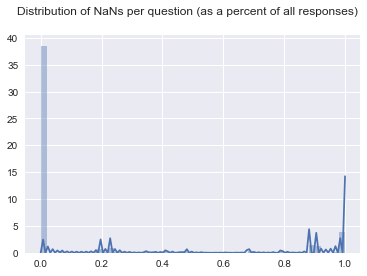

In [11]:
# distribution of NA per question...

# find % NA for each questoin
# make into list
# make histogram
import math
import statsmodels
nan_percents = df_train.isnull().sum() / len(df_train)
sns.distplot(nan_percents)
sns.plt.suptitle('Distribution of NaNs per question (as a percent of all responses)')
plt.show()

In [12]:
num_all_na = sum(df_train.isnull().sum()==len(df_train))

Most questions have no NAN, but a bunch ({{num_all_na}}) have all NAN. If everything is NAN, does imputing even make sense? My initial thought is no, as imputation usually relies on some non_NA values that exist to make informed guesses about the missing data. Since these columns have NA for each respondent, I am tempted to throw them out entirely.

However, as I said before, a lot of the questions have coded responses, where negative responses are indicative of a missing response. 

In [13]:
df_train_good_dtypes = df_train.select_dtypes(include=(int, float))
num_ints_floats = df_train_good_dtypes.shape[1]

There are {{num_ints_floats}} int or float variables out of {{df_train.shape[1]}} total variables. So pretty much all variables have outputs that are numeric (even if these numbers are most often representitative of categories).

In [14]:
num_neg_vals = df_train_good_dtypes.apply(lambda x: sum(x<0), axis=0)
# apply a lambda function to sum up all of the rows (for each col) that has a negative value
num_neg_vals.head()

challengeID       0
m1intmon       1459
m1intyr           0
m1lenhr         253
m1lenmin         57
dtype: int64

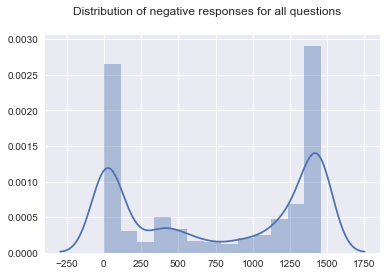

In [15]:
sns.distplot(num_neg_vals)
sns.plt.suptitle('Distribution of negative responses for all questions')
plt.show()

Hmmm. The above histogram shows that most questions either have 0 negative values, or lots. All the way on the right, you can see that there are a lot of questions that have ~1500 negative values. Since there are {{len(df_train)}} rows, I will assume that this right most bar just means ALL rows are negative in these columns. That is not helpful.

So, we want to deal with a) the absolute missing values (NAs) and with b) the coded missing values (negative numbers). 

### NA columns

1. If the entire column is NA, there is not much we can hope to do the way of imputation, so let's leave as is. 
2. For those columns where not all rows are NA, perhaps we can make a difference.

Which columns should we try to tackle, here? Let's just look at one column, first:

In [16]:
nans = nan_percents.reset_index(name='percent_NA')
nans.query('.01<percent_NA < .04')

,index,percent_NA
335,cm1finjail,0.011652
6900,cmf4fevjail,0.032899


Questions above have only a relatively few NAs. Can we use the sklearn imputer?

In [17]:
test_impute = df_train[['cm1finjail','cmf4fevjail','m1intmon']]
test_impute.isnull().sum()

cm1finjail     17
cmf4fevjail    48
m1intmon        0
dtype: int64

In [18]:
from fancyimpute import SimpleFill
filled = SimpleFill('median').complete(test_impute)

In [19]:
filled = pd.DataFrame(filled)
filled.isnull().sum()
# so the SimpleFill works 

0    0
1    0
2    0
dtype: int64

This worked. We added the median and now have no missing values for these two columns.

What about using a more complicated filler?

In [20]:
from fancyimpute import MICE 
test_array = np.asarray(test_impute) # convert to np array
test_array.shape

(1459, 3)

In [21]:
mice_filled = MICE(n_imputations=5).complete(test_array) # complete the two columns in test_array
pd.DataFrame(mice_filled).isnull().sum() # this works too!

[MICE] Completing matrix with shape (1459, 3)
[MICE] Starting imputation round 1/15, elapsed time 0.000
[MICE] Starting imputation round 2/15, elapsed time 0.006
[MICE] Starting imputation round 3/15, elapsed time 0.010
[MICE] Starting imputation round 4/15, elapsed time 0.012
[MICE] Starting imputation round 5/15, elapsed time 0.016
[MICE] Starting imputation round 6/15, elapsed time 0.021
[MICE] Starting imputation round 7/15, elapsed time 0.026
[MICE] Starting imputation round 8/15, elapsed time 0.057
[MICE] Starting imputation round 9/15, elapsed time 0.060
[MICE] Starting imputation round 10/15, elapsed time 0.069
[MICE] Starting imputation round 11/15, elapsed time 0.083
[MICE] Starting imputation round 12/15, elapsed time 0.085
[MICE] Starting imputation round 13/15, elapsed time 0.086
[MICE] Starting imputation round 14/15, elapsed time 0.087
[MICE] Starting imputation round 15/15, elapsed time 0.088


0    0
1    0
2    0
dtype: int64

In [22]:
test_mice_filled_df = pd.DataFrame(mice_filled)
test_mice_filled_df.columns = test_impute.columns.values
test_mice_filled_df.head()

,cm1finjail,cmf4fevjail,m1intmon
0,0.0,1.0,-3.0
1,0.0,0.0,-3.0
2,0.0,0.0,-3.0
3,0.0,1.0,-3.0
4,0.0,0.0,-3.0


So the MICE imputer worked too. MICE uses some fancy math, but the basic story is that we are using regression to make a prediction for the missing value, given the other values in that row for other columns.

Let's try to do it for the entire kit and caboodle! We will need to only do this for int or float variables in df_train, which fortunately is most of them. 

MICE will fail if we try to run for any columns that are all NaN, so let's get rid of those first.

In [23]:
# get rid of 100% NaN cols 
# but keep on hand to maybe add back?
df_train_no_full_NAs = df_train_good_dtypes.dropna(axis=1,how='all')
df_train_no_full_NAs.head()

,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,m1a3,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
5,6,-3,0,25,1,1,10.593024,1,1,1,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3,-3.000000,10.255825
6,7,-3,0,35,1,1,531.335144,1,1,1,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3,10.972726,10.859800
8,9,-3,0,30,1,1,90.466721,0,1,1,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3,9.842380,9.566678
9,10,-3,0,33,1,1,6.155746,1,1,1,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3,-3.000000,10.105870
12,13,-3,1,-3,1,1,5.496325,0,1,1,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3,-3.000000,9.566678


In [24]:
# train_array = np.asarray(df_train_no_full_NAs)
# train_array.shape

In [25]:
# # this takes a long time!
# train_mice =  MICE(n_imputations=2).complete(train_array)
# mice_impute_df_train = pd.DataFrame(train_mice)
# mice_impute_df_train.columns = df_train_no_full_NAs.columns.values
# mice_impute_df_train.head()
# mice_impute_df_train.to_pickle('train_mice')

In [26]:
# mice_impute_df_train = pd.DataFrame(train_mice)
# mice_impute_df_train.columns = df_train_no_full_NAs.columns.values
# mice_impute_df_train.head()
# mice_impute_df_train.to_pickle('train_mice')

### Mean impute

In [27]:
mean_impute_df_train = SimpleFill('mean').complete(df_train_no_full_NAs)
mean_impute_df_train = pd.DataFrame(mean_impute_df_train)
mean_impute_df_train.columns = df_train_no_full_NAs.columns.values
mean_impute_df_train.head()

,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,m1a3,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,6.0,-3.0,0.0,25.0,1.0,1.0,10.593024,1.0,1.0,1.0,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3.0,-3.000000,10.255825
1,7.0,-3.0,0.0,35.0,1.0,1.0,531.335144,1.0,1.0,1.0,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3.0,10.972726,10.859800
2,9.0,-3.0,0.0,30.0,1.0,1.0,90.466721,0.0,1.0,1.0,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3.0,9.842380,9.566678
3,10.0,-3.0,0.0,33.0,1.0,1.0,6.155746,1.0,1.0,1.0,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3.0,-3.000000,10.105870
4,13.0,-3.0,1.0,-3.0,1.0,1.0,5.496325,0.0,1.0,1.0,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3.0,-3.000000,9.566678


In [33]:
mean_all_training = pd.merge(mean_impute_df_train, non_na_y_train_materialHardship, on='challengeID')

### Median impute

In [28]:
median_impute_df_train = SimpleFill('median').complete(df_train_no_full_NAs)
median_impute_df_train = pd.DataFrame(median_impute_df_train)
median_impute_df_train.columns = df_train_no_full_NAs.columns.values
median_impute_df_train.head()

,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,m1a3,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,6.0,-3.0,0.0,25.0,1.0,1.0,10.593024,1.0,1.0,1.0,...,8.51570,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3.0,-3.000000,10.255825
1,7.0,-3.0,0.0,35.0,1.0,1.0,531.335144,1.0,1.0,1.0,...,-3.00000,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3.0,10.972726,10.859800
2,9.0,-3.0,0.0,30.0,1.0,1.0,90.466721,0.0,1.0,1.0,...,-3.00000,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3.0,9.842380,9.566678
3,10.0,-3.0,0.0,33.0,1.0,1.0,6.155746,1.0,1.0,1.0,...,-3.00000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3.0,-3.000000,10.105870
4,13.0,-3.0,1.0,-3.0,1.0,1.0,5.496325,0.0,1.0,1.0,...,10.78074,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3.0,-3.000000,9.566678


Let's add the material hardship y values back on so we have a full training df.

In [30]:
median_all_training = pd.merge(median_impute_df_train, non_na_y_train_materialHardship, on='challengeID')
median_all_training.head()

,challengeID,m1intmon,m1lenhr,m1lenmin,cm1fint,cm1citsm,m1citywt,innatsm,incitysm,m1a3,...,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1,materialHardship
0,6.0,-3.0,0.0,25.0,1.0,1.0,10.593024,1.0,1.0,1.0,...,10.558813,-3.000000,-3.000000,7.022328,-3.000000,10.564085,-3.0,-3.000000,10.255825,1
1,7.0,-3.0,0.0,35.0,1.0,1.0,531.335144,1.0,1.0,1.0,...,-3.000000,9.660643,9.861125,-3.000000,10.991854,-3.000000,-3.0,10.972726,10.859800,0
2,9.0,-3.0,0.0,30.0,1.0,1.0,90.466721,0.0,1.0,1.0,...,-3.000000,11.689877,9.373199,-3.000000,8.194868,-3.000000,-3.0,9.842380,9.566678,2
3,10.0,-3.0,0.0,33.0,1.0,1.0,6.155746,1.0,1.0,1.0,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,10.564085,-3.0,-3.000000,10.105870,1
4,13.0,-3.0,1.0,-3.0,1.0,1.0,5.496325,0.0,1.0,1.0,...,-3.000000,-3.000000,-3.000000,8.944119,-3.000000,9.781718,-3.0,-3.000000,9.566678,2


# 3. Training data export<a name="ims"></a>

Let's now export various training dataframes so we can train on validation data in our next notebook. Here are the various flavors available:

- Plain jane training set (with crap ton of NAs): df_train

Imputed: 

- Mean imputation method: mean_impute_df_train
- Median imputation method: median_impute_df_train
- ~~MICE imputation method: mice_impute_df_train~~

All of the above should be merged onto the y values given by non_na_y_train_materialHardship. 

Augmented:

- ~~Augmented data: augmented_df_train~~

Class balanced:

- Balanced label data: balanced_label_df_train (goes with final_over_balanced['materialHardship']. Can just use final_over_balanced for full features + classes df)


In [50]:
mean_impute_df_train.to_pickle('mean_impute_df_train')
median_impute_df_train.to_pickle('median_impute_df_train')

In [35]:
mean_all_training.to_pickle('mean_impute_df_train_with_labels')
median_all_training.to_pickle('median_impute_df_train_with_labels')